In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('Tweets_cleaned.csv')
df = df[['body_text_clean','label']]

df = df[pd.notnull(df['body_text_clean'])]
df.rename(columns = {'body_text_clean':'narrative'}, inplace = True)

df.rename(columns = {'label':'Product'}, inplace = True)

In [13]:
df.head()

,narrative,Product
0,this totally topped off my week,NOT_SARCASM
1,wow how freaking awesome was that,NOT_SARCASM
2,summers over and it was shit only sunny day wa...,NOT_SARCASM
3,did you know that one of bolshoi ballet member...,NOT_SARCASM
4,i just love missing the bus,SARCASM


In [14]:
df.shape


(566, 2)

In [15]:
df.index = range(566)

In [16]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

6506

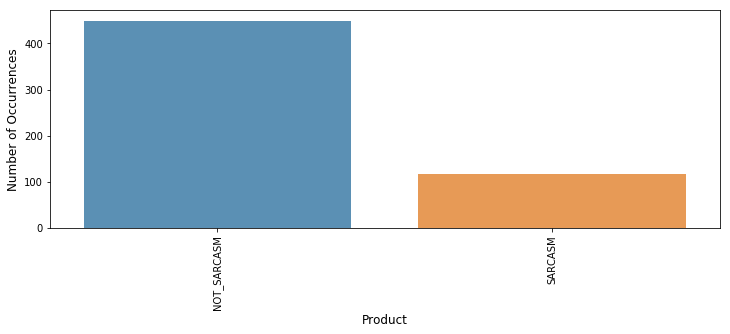

In [17]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [18]:

def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [19]:

print_complaint(12)

lilylovehermore i knew id heard that name somewhere
Product: NOT_SARCASM


In [20]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [21]:
df['narrative'][20]

'tyga feat kirko bangz out this bitch'

In [22]:

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [23]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [24]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [39]:
train_tagged.values[30]

TaggedDocument(words=['the', 'only', 'way', 'that', 'this', 'will', 'work', 'is', 'if', 'you', 'love', 'me', 'when', 'it', 'hurts'], tags=['NOT_SARCASM'])

In [26]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [27]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████| 396/396 [00:00<00:00, 396880.38it/s]


In [28]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 396/396 [00:00<?, ?it/s]


Wall time: 733 ms


In [29]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [30]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [31]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7470588235294118
Testing F1 score: 0.7295486625391067


In [45]:
y_pred

array(['NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'SARCASM', 'SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM', 'NOT_SARCASM',
       'N

In [74]:
df1 = pd.read_csv('Input.csv')
df1['narrative'] = df1['narrative'].apply(cleanText)
test_tagged1 = df1.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [75]:
y_test1, X_test1 = vec_for_learning(model_dbow, test_tagged1)

In [76]:
y_pred = logreg.predict(X_test1)

In [77]:
y_pred

array(['SARCASM', 'NOT_SARCASM', 'NOT_SARCASM'], dtype='<U11')